In [ ]:
#@title Setup
from datetime import datetime, timedelta
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error

# Ignore warnings
filterwarnings('ignore')

# Set seed
SEED = 123
np.random.seed(SEED)

# 🎯 Step 1 - Problem Definition

Build a data science solution that addresses the following:

1. Predict Airline Price: Build a model that forecasts the price of a flight based on its booking date. You will be provided a historical booking data that includes departure date, booking date, airline, destination and such.

2. Scenario Planning for Savings: Once your model can predict the price, we want to create a “what-if” feature. This feature will help users see how much they might save or spend by booking on different dates. For example, if a user books a flight from San Francisco to New York on December 15, they could explore alternative booking dates to see if booking on a different date would yield a better price.

In [ ]:
# Load data
df_booking = pd.read_csv("google_flights_airfare_data.csv")
df_booking.head()

,transaction_id,flight_id,airline,origin,destination,booking_dt,departure_dt,price,fare_class
0,898b2db0d,ced9a2,American Airlines,ORD,BOS,2024-04-02 14:00:10,2024-07-09 07:47:00,327.15,Economy
1,5b8144206,ced9a2,American Airlines,ORD,BOS,2024-05-19 08:44:17,2024-07-09 07:47:00,191.25,Economy
2,2e458f769,ced9a2,American Airlines,ORD,BOS,2024-02-23 22:11:51,2024-07-09 07:47:00,579.79,Economy
3,2c9e3e129,ced9a2,American Airlines,ORD,BOS,2024-04-22 23:43:37,2024-07-09 07:47:00,579.06,Economy
4,9de7ad563,ced9a2,American Airlines,ORD,BOS,2024-04-28 17:55:53,2024-07-09 07:47:00,207.06,Economy


# 🗺️ Step 2 - Exploratory Data Analysis

✍️ The Exploratory Data Analysis (EDA) section delves into the provided airfare dataset to understand its characteristics, identify patterns, and uncover insights that inform model development. Here's a guideline you can consider when approaching section:

1. Generate tables and/or charts that illustrate insights.
2. Identify potential data quality issues that require addressing.
3. Discover patterns and trends that can guide feature engineering and model selection.

## Overview

In [ ]:
# Create an exploratory dataset
df_eda = df_booking.copy()

# Set select fields as datetime data type
df_eda['booking_dt'] = pd.to_datetime(df_eda['booking_dt'])
df_eda['departure_dt'] = pd.to_datetime(df_eda['departure_dt'])

# Compute delta
df_eda['delta'] = (df_eda['booking_dt'] - df_eda['departure_dt']).dt.days

# Let's do an overview
df_eda.describe()

,booking_dt,departure_dt,price,delta
count,225209,225209,225209.000000,225209.000000
mean,2023-04-03 08:01:28.147392,2023-07-02 23:32:57.766874112,509.673779,-91.146757
min,2021-10-12 11:58:26,2022-04-09 04:12:00,16.610000,-180.000000
25%,2022-10-02 01:24:33,2023-01-03 18:56:00,245.290000,-136.000000
50%,2023-04-03 14:12:02,2023-06-29 06:27:00,417.280000,-91.000000
75%,2023-10-03 17:29:47,2024-01-02 13:18:00,654.300000,-46.000000
max,2024-09-12 14:58:34,2024-09-15 06:11:00,6639.680000,-2.000000
std,NaN,NaN,385.889088,51.656842


## Missingness

In [ ]:
# What percentage of the records are missing per each fieldf
df_eda.isna().mean()

,0
transaction_id,0.0
flight_id,0.0
airline,0.0
origin,0.0
destination,0.0
booking_dt,0.0
departure_dt,0.0
price,0.0
fare_class,0.0
delta,0.0


## Univariate Analysis

In [ ]:
# How many unique airlines are there?
print(f"Airlines: {df_eda['airline'].unique()}")

Airlines: ['American Airlines' 'Delta Air Lines' 'United Airlines']


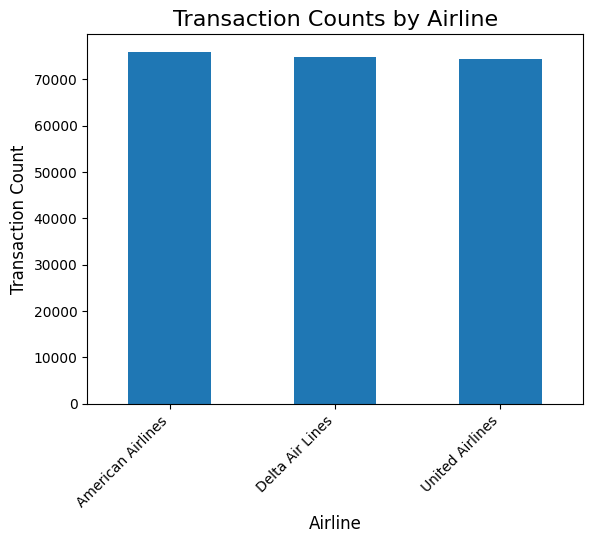

In [ ]:
# Transactions per airline
df_eda.groupby("airline")['transaction_id'].count().plot(kind='bar')
# Customize the plot
plt.title("Transaction Counts by Airline", fontsize=16)
plt.xlabel("Airline", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# How many origin and destination locations are there?
print(f"Origin: {df_eda['origin'].unique()}")
print(f"Destination: {df_eda['destination'].unique()}")

Origin: ['ORD' 'SFO' 'ATL' 'JFK' 'LAX']
Destination: ['BOS' 'DFW' 'MIA' 'SEA' 'DEN']


In [ ]:
# How many fare classes are there?
print(f"Fare Class: {df_eda['fare_class'].unique()}")

Fare Class: ['Economy' 'Business' 'First']


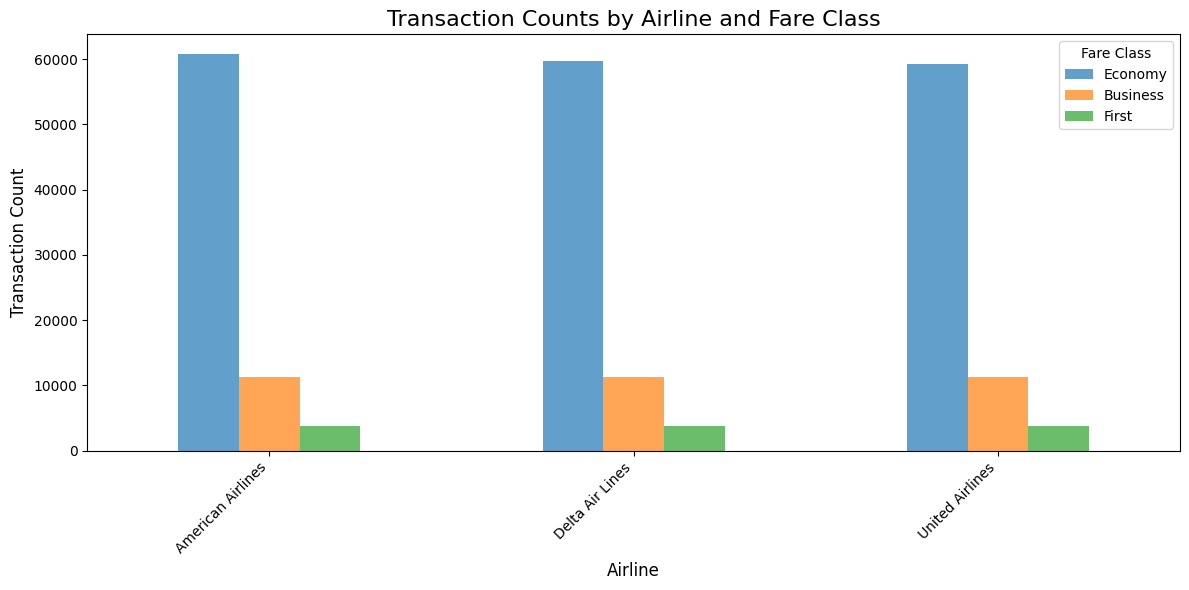

In [ ]:
# Define the desired order of fare classes
fare_class_order = ['Economy', 'Business', 'First']

# Group and unstack the data, then reorder columns
plot_data = df_eda.groupby(['airline', 'fare_class'])['transaction_id'].count().unstack()
plot_data = plot_data[fare_class_order]  # Reorder columns

# Create the bar plot
ax = plot_data.plot(kind='bar', alpha=0.7, figsize=(12, 6))

# Customize the plot
plt.title("Transaction Counts by Airline and Fare Class", fontsize=16)
plt.xlabel("Airline", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Fare Class", fontsize=10)

plt.tight_layout()
plt.show()

## Target Analysis

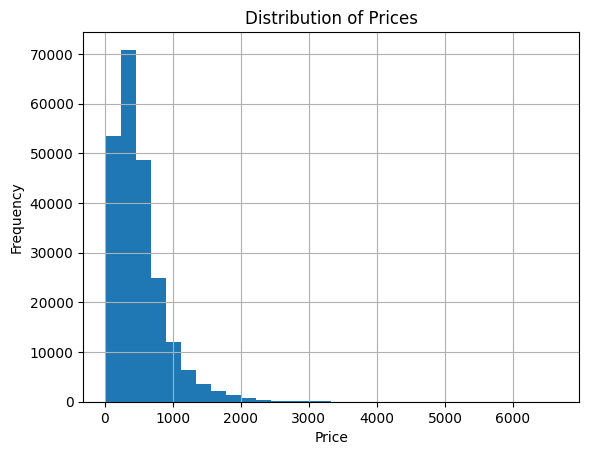

In [ ]:
# Let's understand the distribution of price
df_eda['price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()

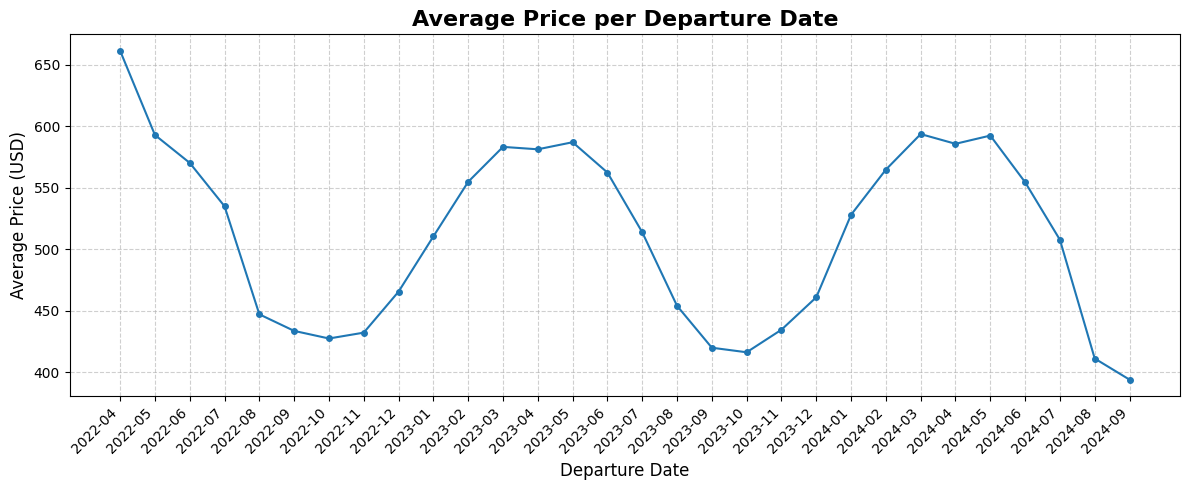

In [ ]:
# Let's plot seasonality, let's extact year month
df_eda['departure_year_month'] = df_eda['departure_dt'].dt.to_period('M')

avg_price_per_departure = df_eda.groupby('departure_year_month').agg({'price': 'mean'})
avg_price_per_departure.index = avg_price_per_departure.index.astype(str)

# Plotting the average price per booking date
plt.figure(figsize=(12, 5))
plt.plot(avg_price_per_departure.index, avg_price_per_departure.values, marker='o', linestyle='-', markersize=4)

# Enhancing plot aesthetics
plt.title("Average Price per Departure Date", fontsize=16, weight='bold')
plt.xlabel("Departure Date", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

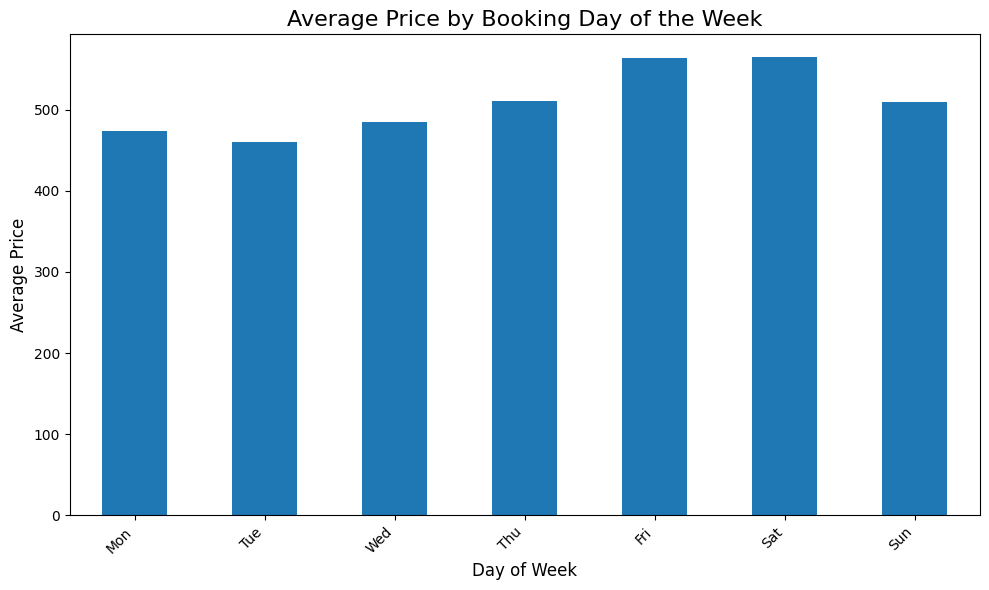

In [ ]:
# Assuming your DataFrame is called 'df_booking' and has a 'booking_dt' column
df_eda['day_of_week'] = df_eda['booking_dt'].dt.dayofweek  # Extract day of week (0=Monday, 6=Sunday)

# Calculate mean and standard error for each day of the week
plot_data = df_eda.groupby('day_of_week')['price'].agg('mean')  # sem = standard error of the mean
plot_data.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']  # Replace day numbers with day names

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))

# Create a bar plot using pandas
plot_data.plot(kind='bar')

# Customize the plot
plt.title("Average Price by Booking Day of the Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

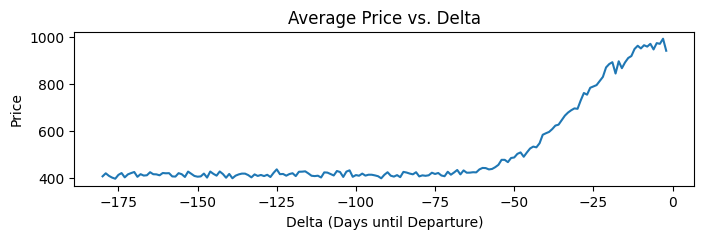

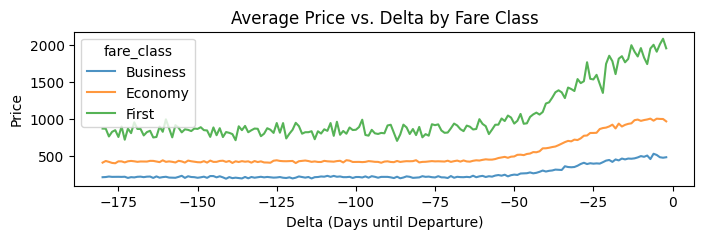

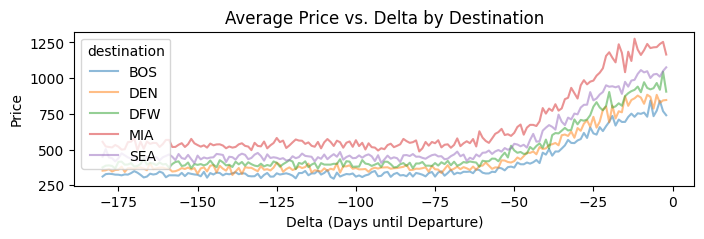

In [ ]:
# Let's compute the average per delta
df_eda.groupby('delta')['price'].mean().plot(figsize=(8, 2))
plt.xlabel('Delta (Days until Departure)')
plt.ylabel('Price')
plt.title('Average Price vs. Delta')
plt.show()

# Let's do this by fare class
df_eda.groupby(['delta','fare_class'])['price'].mean().unstack().plot(alpha=0.8, figsize=(8, 2))
plt.xlabel('Delta (Days until Departure)')
plt.ylabel('Price')
plt.title('Average Price vs. Delta by Fare Class')
plt.show()

# Let's do this by destination
df_eda.groupby(['delta','destination'])['price'].mean().unstack().plot(alpha=0.5, figsize=(8, 2))
plt.xlabel('Delta (Days until Departure)')
plt.ylabel('Price')
plt.title('Average Price vs. Delta by Destination')
plt.show()

# 🛢️ Step 3 - Data Preparation

✍️ Data preparation transforms raw data into a suitable format for machine learning models, enhancing their accuracy and efficiency. Your task is to clean, transform, and organize the airfare data. Here are suggestions:

*   Format Fields: Ensure data types are appropriate for analysis (e.g., datetime, categorical).
*   Split Data: Divide the dataset into training, validation, and testing sets to evaluate model performance robustly. Consider chronological order for time-series data.

💡 You are not restricted to these steps. If you identify additional steps to enhance the data, feel free to include them!

## Format Fields

In [ ]:
# Set select fields as datetime data type
df_booking['booking_dt'] = pd.to_datetime(df_booking['booking_dt'])
df_booking['departure_dt'] = pd.to_datetime(df_booking['departure_dt'])

# Set select fields as category data type
for col in ['airline', 'origin', 'destination', 'fare_class']:
    df_booking[col] = df_booking[col].astype('category')

## Split Data

In [ ]:
def split_time_series(data: pd.DataFrame, time_column: str, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
    """
    Splits a time series dataset into train, valid, and test sets based on time.

    Parameters:
        data (pd.DataFrame): The dataset to split.
        time_column (str): The name of the column containing timestamps.
        train_ratio (float): The proportion of data for the training set (default is 0.7).
        valid_ratio (float): The proportion of data for the valid set (default is 0.2).
        test_ratio (float): The proportion of data for the test set (default is 0.1).

    Returns:
        train (pd.DataFrame): The training set (oldest 70% of data by default).
        valid (pd.DataFrame): The valid set (next 20% of data by default).
        test (pd.DataFrame): The test set (most recent 10% of data by default).
    """

    # Ensure data is sorted by the time column
    data = data.sort_values(by=time_column).reset_index(drop=True)

    # Compute split indices
    n = len(data)
    train_end = int(n * train_ratio)
    valid_end = train_end + int(n * valid_ratio)

    # Split the dataset
    train = data.iloc[:train_end]
    valid = data.iloc[train_end:valid_end]
    test = data.iloc[valid_end:]

    # Name the datasets
    train.name = 'Train'
    valid.name = 'Valid'
    test.name = 'Test'

    # Reset index
    train.reset_index(drop=True, inplace=True)
    valid.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    return train, valid, test

df_train, df_valid, df_test = split_time_series(df_booking, time_column='departure_dt')

for _df in [df_train, df_valid, df_test]:
    print(f"{_df.name} Shape: {_df.shape} | Departure Range: {_df['departure_dt'].min()} - {_df['departure_dt'].max()}")

Train Shape: (157646, 9) | Departure Range: 2022-04-09 04:12:00 - 2023-11-27 10:49:00
Valid Shape: (45041, 9) | Departure Range: 2023-11-27 10:49:00 - 2024-04-19 12:30:00
Test Shape: (22522, 9) | Departure Range: 2024-04-19 12:30:00 - 2024-09-15 06:11:00


In [ ]:
# Split data into X and y frames
X_train = df_train.drop(columns=['price'])
y_train = df_train['price']
X_valid = df_valid.drop(columns=['price'])
y_valid = df_valid['price']
X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

# 🚀 Step 4 - Feature Engineering

✍️ Feature engineering boosts model performance! It's about creating new features from existing ones to help the model better understand the data and improve predictions.

Here are suggestions to help you create new features:

1. **Compute Delta**: Calculate the time difference between booking and departure dates, as it's likely a key factor in pricing.
2. **Decompose Timestamps**: Extract valuable information from booking and departure dates, like year, month, day of the week, etc.

💡 If you think of any other features that could be insightful, go ahead and experiment. Feature engineering is all about finding what works best for your model!

## Compute Delta

In [ ]:
# Let's compute the delta between the depature_dt and booking_dt
def compute_delta(df: pd.DataFrame, target_column: str, base_column: str):
    """
    Calculates the time difference (in days) between two datetime columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): Name of the target datetime column.
        base_column (str): Name of the base datetime column.

    Returns:
        pd.DataFrame: The DataFrame with the 'delta' column added.
    """
    # Calculate the difference between 'booking_dt' and 'departure_dt' in days
    df['delta'] = (df['booking_dt'] - df['departure_dt']).dt.days
    return df

X_train = compute_delta(X_train, 'departure_dt', 'booking_dt')
X_valid = compute_delta(X_valid, 'departure_dt', 'booking_dt')
X_test = compute_delta(X_test, 'departure_dt', 'booking_dt')

## Decompose TS

In [ ]:
# Here we decompose the datetime variable
def decompose_datetime(df: pd.DataFrame, date_column: list):
    """
    Decomposes datetime columns into individual time features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_column (list): List of datetime columns to decompose.

    Returns:
        pd.DataFrame: The DataFrame with added time features.
    """
    for field in date_column:
        # Extract datetime properties using the .dt accessor
        dt_series = df[field].dt

        # Create new columns for year, month, day, dayofweek, dayofyear
        df.loc[:, field + '_year'] = dt_series.year
        df.loc[:, field + '_month'] = dt_series.month
        df.loc[:, field + '_day'] = dt_series.day
        df.loc[:, field + '_dayofweek'] = dt_series.dayofweek
        df.loc[:, field + '_dayofyear'] = dt_series.dayofyear

    return df

# Decompose datetime in train
X_train = decompose_datetime(X_train, ['booking_dt', 'departure_dt'])
X_valid = decompose_datetime(X_valid, ['booking_dt', 'departure_dt'])
X_test = decompose_datetime(X_test, ['booking_dt', 'departure_dt'])

# 📍 Step 5 - Feature Selection

✍️ Feature selection prevents model overfitting and improves training speed. Find the most relevant features for model prediction. You can consider a method such as the Random Forest Feature Importance.

## RF Feature Selection

In [ ]:
candidate_features = [
 'airline',
 'origin',
 'destination',
 'fare_class',
 'delta',
 'booking_dt_year',
 'booking_dt_month',
 'booking_dt_day',
 'booking_dt_dayofweek',
 'booking_dt_dayofyear',
 'departure_dt_year',
 'departure_dt_month',
 'departure_dt_day',
 'departure_dt_dayofweek',
 'departure_dt_dayofyear']

# Create a copy of X_train to avoid modifying the original DataFrame
X_train_encoded = X_train[candidate_features].copy()

# Initialize LabelEncoder
encoder = LabelEncoder()

# Apply Label Encoding to categorical features
for col in ['airline', 'origin', 'destination', 'fare_class']:
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col])

# Initialize SelectKBest with f_regression as the scoring function
selector = SelectKBest(f_regression, k=10)  # Select top 10 features

# Fit SelectKBest to the encoded training data
selector = selector.fit(X_train_encoded, y_train)

# Get the selected features
selected_features = X_train_encoded.columns[selector.get_support()].tolist()
print(f"Selected features: {selected_features}")

Selected features: ['airline', 'destination', 'fare_class', 'delta', 'booking_dt_year', 'booking_dt_dayofweek', 'departure_dt_year', 'departure_dt_month', 'departure_dt_dayofweek', 'departure_dt_dayofyear']


## Feature Importance

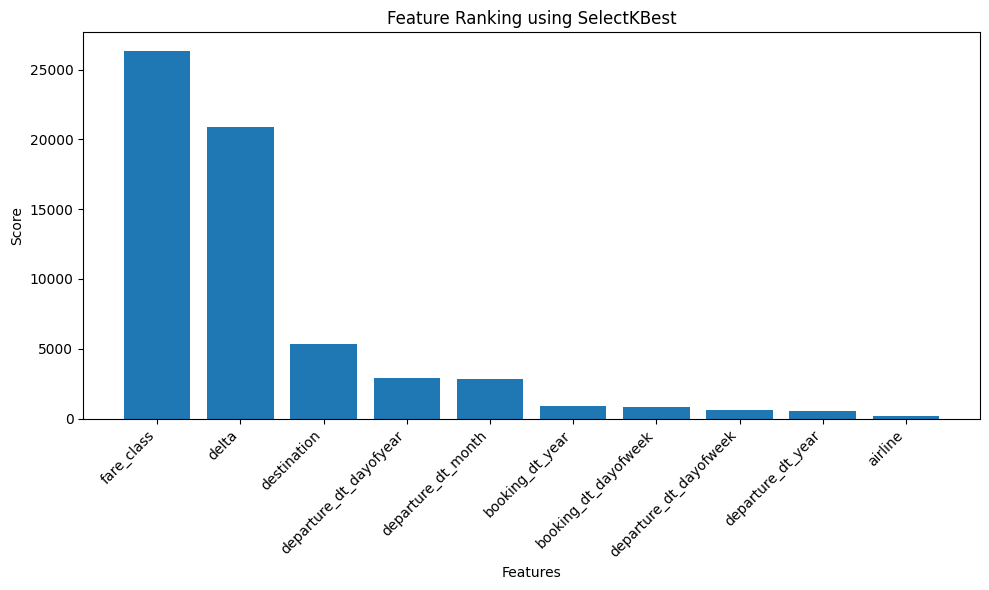

In [ ]:
# Get feature scores and p-values
feature_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to display feature rankings
df_feature_ranking = pd.DataFrame({'Feature': X_train_encoded.columns,
                                   'Score': feature_scores,
                                   'P-value': p_values})

# Filter the feature ranking DataFrame to include only selected features
df_selected_features = (
    df_feature_ranking[df_feature_ranking['Feature'].isin(selected_features)]
        .sort_values(by='Score', ascending=False)
        .reset_index(drop=True)
)

# Create a bar plot of feature scores
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(df_selected_features['Feature'], df_selected_features['Score'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Ranking using SelectKBest')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Filter Columns

In [ ]:
# Filter predictor data based on the selected features
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
X_test = X_test[selected_features]

# 🤖 Step 6 - Model Selection

✍️ Model selection is where we pick the champion algorithm that will power our predictions. It's about carefully evaluating different models and choosing the one that best suits our dataset and prediction task.

Your task is to experiment with different model architectures, train them, and assess their performance.

Here are suggestions on how to start this process:

1. Baseline Model: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. Hyperparameter Tuning: Fine-tune the parameters of your chosen model using techniques like grid search or random search to unlock its full potential and achieve optimal performance.

💡 Consider using the XGBoost model, or any other models (e.g., linear regression, random forest).

## Baseline Model

In [ ]:
# Initialize and train the XGBoost model
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    random_state=SEED,
    enable_categorical=True
)

baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Predictions
y_pred_train = baseline_model.predict(X_train)
y_pred_valid = baseline_model.predict(X_valid)
y_pred_test = baseline_model.predict(X_test)

# Evaluation
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_valid = mean_absolute_percentage_error(y_valid, y_pred_valid)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Round it to the 2 decimal places
for name, mape in zip(['Train', 'Valid', 'Test'], [mape_train, mape_valid, mape_test]):
    print(f"Mean Absolute Percentage Error (MAPE)")
    print(f"{name}: {mape*100:.2f}%")

Mean Absolute Percentage Error (MAPE)
Train: 48.99%
Mean Absolute Percentage Error (MAPE)
Valid: 61.06%
Mean Absolute Percentage Error (MAPE)
Test: 60.70%


## Hyperparameter Tuning

In [ ]:
# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [30, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    enable_categorical=True
)

# Number of random combinations to try
n_iter = 30

# Generate random combinations of parameters
param_list = list(ParameterSampler(param_distributions=param_dist, n_iter=n_iter, random_state=SEED))

# Initialize results storage
best_params = None
best_score = float('inf')

# Train and evaluate models for each parameter combination
for i, params in enumerate(param_list):
    print(f"[{i+1} / {n_iter}] Testing parameters: {params}")

    # Initialize the XGBoost model with current parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=SEED,
        enable_categorical=True,
        **params
    )

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    # Predict on validation set
    y_pred = model.predict(X_valid)

    # Calculate validation score
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print(f"Validation MAPE: {mape}")

    # Update best parameters and score if current score is better
    if mape < best_score:
        best_score = mape
        best_params = params

print("\nBest parameters found:")
print(best_params)
print(f"Best validation MAPE: {best_score:.3f}")

[1 / 30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
Validation MAPE: 0.6266215199243197
[2 / 30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Validation MAPE: 0.6267726406109047
[3 / 30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 10, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
Validation MAPE: 0.7849653016852012
[4 / 30] Testing parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 1.0}
Validation MAPE: 0.6601592082038554
[5 / 30] Testing parameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 9, 'lear

In [ ]:
# Initialize the best model with the identified parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    enable_categorical=True,
    **best_params
)

# Train the model on the entire training set
best_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_valid = best_model.predict(X_valid)
y_pred_test = best_model.predict(X_test)

# Evaluation
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_valid = mean_absolute_percentage_error(y_valid, y_pred_valid)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Round it to the 2 decimal places
for name, mape in zip(['Train', 'Valid', 'Test'], [mape_train, mape_valid, mape_test]):
    print(f"Mean Absolute Percentage Error (MAPE)")
    print(f"{name}: {mape*100:.2f}%")

Mean Absolute Percentage Error (MAPE)
Train: 58.56%
Mean Absolute Percentage Error (MAPE)
Valid: 59.12%
Mean Absolute Percentage Error (MAPE)
Test: 60.54%


# 📊 Step 7 - Evaluation

✍️ Model evaluation is where we put our model to the test and determine its true performance. It's about rigorously assessing how well our chosen model generalizes to unseen data and identifying any areas for improvement. Your task is to evaluate your model using a variety of metrics and techniques, focusing on:

Consider evaluating your model with the following points:

1. **Benchmark Comparison:** Compare your model's performance against a simple business method. This helps provide context and demonstrate the model's advantages over a simpler approach.

2. **Simpson's Paradox:** Note that model performance may vary when you assess the subgroups. Do you see that the ML approach is consistently better across subgroups such as airfare_class?

💡 Remember, model evaluation is more than just looking at a single metric. Consider using multiple metrics (e.g., MAPE, RMSE, R-squared) to get a comprehensive view of your model's performance.

## Evaluation Dataset

In [ ]:
# Copy the test dataset to create an evaluation dataset
df_eval = df_test.copy()

# Store the prediction
df_eval = df_eval.assign(Model=y_pred_test)

# Add delta
df_eval = compute_delta(df_eval, 'departure_dt', 'booking_dt')

## Business Method


In [ ]:
# Benchmark Prediction
def benchmark_predict(train: pd.DataFrame, test: pd.DataFrame):
    """
    Calculates a benchmark prediction for the target variable ('price')
    based on the average price for each 'delta' value in the training data.

    Args:
        train (pd.DataFrame): The training data containing 'delta' and 'price' columns.
        test (pd.DataFrame): The test data containing the 'delta' column.

    Returns:
        np.ndarray: An array of benchmark predictions for the test data.
    """

    # Make copies
    train = train.copy()
    test = test.copy()

    # Compute delta
    train = compute_delta(train, 'departure_dt', 'booking_dt')
    test = compute_delta(test, 'departure_dt', 'booking_dt')

    # Calculate the average price for each 'delta' value in the training data.
    train = train.groupby('delta')['price'].mean().rename('benchmark_train_pred')

    # Merge the test data with the average prices calculated from the training data.
    return test.merge(train, on='delta', how='left')['benchmark_train_pred'].values

# Generate predictions
y_pred_business = benchmark_predict(df_train, df_test)
df_eval = df_eval.assign(Benchmark=y_pred_business)

In [ ]:
# Calculate errors

for column in ['Benchmark', 'Model']:

    # Percentage error
    df_eval['MPE_'+column] = (df_eval[column] - df_eval['price']) / df_eval['price']

    # Absolute percentage error (APE)
    df_eval['MAPE_'+column] = df_eval['MPE_'+column].abs()

    # Bias (actual vs pred)
    df_eval['BIAS_'+column] = df_eval[column] - df_eval['price']

# Display errors
df_eval.filter(regex='(PE|APE|BIAS)',axis=1).mean().rename('Errors').round(4)

,Errors
MPE_Benchmark,0.4356
MAPE_Benchmark,0.7429
BIAS_Benchmark,-41.5490
MPE_Model,0.3608
MAPE_Model,0.6054
BIAS_Model,5.0572


In [ ]:
# Let's inspect the errors by airfare class
df_eval.filter(regex='(fare_class|MPE|MAPE|BIAS)',axis=1).groupby('fare_class').mean().loc[['Economy', 'Business', 'First']]

,BIAS_Benchmark,BIAS_Model,MPE_Benchmark,MAPE_Benchmark,MPE_Model,MAPE_Model
fare_class,,,,,,
Economy,-54.432950,3.830719,0.265295,0.587933,0.350916,0.595388
Business,222.194085,6.025561,1.634243,1.662032,0.412126,0.658279
First,-590.625675,20.980063,-0.360001,0.504239,0.366325,0.607868


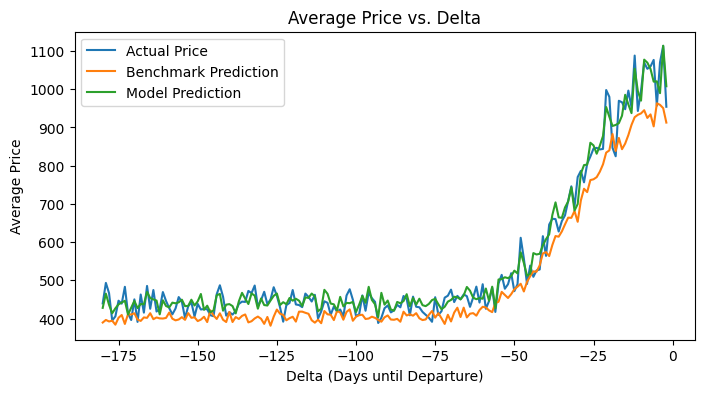

In [ ]:
# Let's look at the actual vs predictions across delta
df_eval.groupby('delta')[['price','Benchmark','Model']].mean().plot(figsize=(8, 4))
plt.xlabel('Delta (Days until Departure)')
plt.ylabel('Average Price')
plt.title('Average Price vs. Delta')
plt.legend(['Actual Price', 'Benchmark Prediction', 'Model Prediction'])  # Add this line
plt.show()

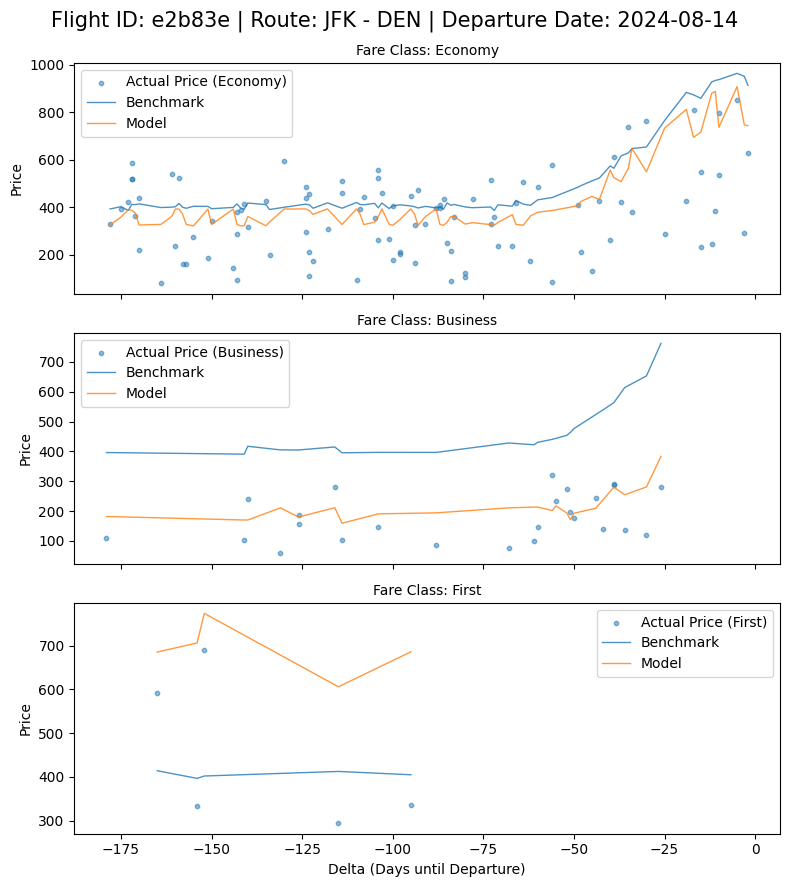

In [ ]:
# Let's compare the actual price, model and benchmark predictions
num_fare_classes = len(df_test['fare_class'].unique())
fig, axes = plt.subplots(nrows=num_fare_classes, ncols=1, figsize=(8, 3 * num_fare_classes), sharex=True)  # Create subplots

# Randomly select flight id
sample = df_test.sample(1).to_dict('records')[0]
df_sample = df_eval[df_eval.flight_id == sample['flight_id']]

# Define the desired order of fare classes
fare_class_order = ['Economy', 'Business', 'First']

# Plot for each fare class in the desired order
for i, fare_class in enumerate(fare_class_order):  # Iterate through fare_class_order
    ax = axes[i]  # Get the current subplot axis
    df_subset = df_sample[df_sample.fare_class == fare_class]

    ax = axes[i]  # Get the current subplot axis
    df_subset = df_sample[df_sample.fare_class == fare_class]

    # Scatter plot
    df_subset.plot.scatter(x='delta', y='price', ax=ax, label=f'Actual Price ({fare_class})',
                            s=10, alpha=0.50)

    # Line plot
    df_subset.groupby('delta')[['Benchmark', 'Model']].mean().plot(
        ax=ax, label=f'{fare_class}', alpha=0.8, linewidth=1
    )

    ax.set_title(f"Fare Class: {fare_class}", fontsize=10)  # Set subplot title
    ax.set_ylabel('Price')  # Set y-axis label
    ax.legend()  # Show legend

plt.suptitle(f"Flight ID: {sample['flight_id']} | Route: {sample['origin']} - {sample['destination']} | Departure Date: {sample['departure_dt'].date()}", fontsize=15)  # Overall title
plt.xlabel('Delta (Days until Departure)')  # Set x-axis label for the entire figure
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# ✈️ Step 8 - Airfare Scenario Planning

✍️ This is the main aim for the ML approach. We want to build a tool that uses ML to help useres make informed booking decisions.

Given the following inputs:

1. Current Date
2. Departure Date
3. Airline
4. Origin
5. Destination
6. Fare Class

Predict the future airfare prices across a range of potential booking dates. Present these predictions in a clear and understandable format. Consider using a chart.

💡 Consider providing an actionable insight that helps users identify the optimal booking date within a specified timeframe (e.g., next 7 days) to potentiallly maximize savings.

In [ ]:
# Choose flight

#@title Example Form
today_date = '2024-11-22' #@param {type:"string"}
departure_date = '2024-12-08' #@param {type:"string"}
airline = 'United Airlines' #@param ['American Airlines', 'Delta Air Lines', 'United Airlines']
origin = 'JFK' #@param ['JFK', 'LAX', 'ORD']
destination = 'LAX' #@param ['JFK', 'LAX', 'ORD']
fare_class = 'Business' #@param ["Economy", "Business", "First"]

# Check that the departure date is greater than the today date
if departure_date <= today_date:
    raise ValueError("Departure date must be greater than today's date.")

In [ ]:
# Create simulation dataset

# Convert dates to datetime objects
today_date_dt = datetime.strptime(today_date, '%Y-%m-%d')
departure_date_dt = datetime.strptime(departure_date, '%Y-%m-%d')

# Calculate the range of delta values
max_days_delta = (departure_date_dt - today_date_dt).days
delta_range = range(0, max_days_delta + 1)  # Include departure date

# Create a list of dictionaries, each representing a row
data = []
for delta in delta_range:
    booking_date_dt = departure_date_dt - timedelta(days=delta)
    data.append({
        'airline': airline,
        'origin': origin,
        'destination': destination,
        'fare_class': fare_class,
        'delta': -delta,  # Delta is negative as it's days until departure
        'delta_from_today': max_days_delta - delta,
        'booking_dt': booking_date_dt,
        'departure_dt': departure_date_dt
    })

# Create a DataFrame from the list of dictionaries
df_sim = pd.DataFrame(data)

# Decompose booking_dt and departure_dt
df_sim = decompose_datetime(df_sim, ['booking_dt', 'departure_dt'])

# Set variables as categorical
for col in ['airline', 'origin', 'destination', 'fare_class']:
    df_sim[col] = df_sim[col].astype('category')

# Generate prediction
df_sim['Forecast'] = best_model.predict(df_sim[selected_features])
df_sim['Current'] = df_sim[df_sim.booking_dt == today_date]['Forecast'].values[0]
df_sim['Savings'] = df_sim['Current'] - df_sim['Forecast']

In [ ]:
df_sim.head()

,airline,origin,destination,fare_class,delta,delta_from_today,booking_dt,departure_dt,booking_dt_year,booking_dt_month,...,booking_dt_dayofweek,booking_dt_dayofyear,departure_dt_year,departure_dt_month,departure_dt_day,departure_dt_dayofweek,departure_dt_dayofyear,Forecast,Current,Savings
0,United Airlines,JFK,LAX,Business,0,16,2024-12-08,2024-12-08,2024,12,...,6,343,2024,12,8,6,343,320.523346,364.64444,44.121094
1,United Airlines,JFK,LAX,Business,-1,15,2024-12-07,2024-12-08,2024,12,...,5,342,2024,12,8,6,343,350.307648,364.64444,14.336792
2,United Airlines,JFK,LAX,Business,-2,14,2024-12-06,2024-12-08,2024,12,...,4,341,2024,12,8,6,343,348.782227,364.64444,15.862213
3,United Airlines,JFK,LAX,Business,-3,13,2024-12-05,2024-12-08,2024,12,...,3,340,2024,12,8,6,343,354.149750,364.64444,10.494690
4,United Airlines,JFK,LAX,Business,-4,12,2024-12-04,2024-12-08,2024,12,...,2,339,2024,12,8,6,343,358.490356,364.64444,6.154083


If you wait 2 day(s) and book on 2024-11-24, you can save $86.63.


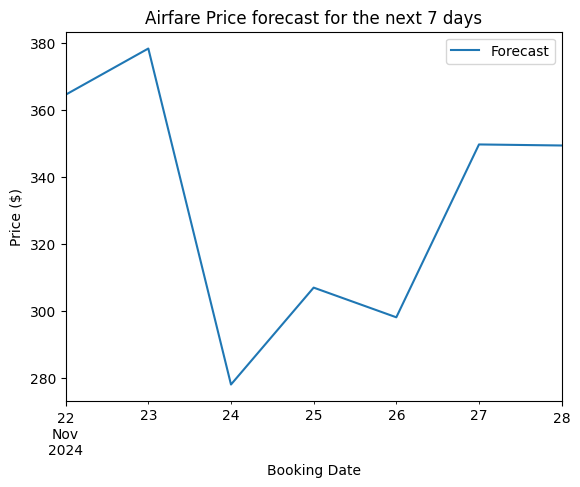

In [ ]:
df_window = df_sim[df_sim.delta_from_today < 7]

max_saving = df_window['Savings'].max()

# Get the rows with the minimum price change
min_change_records = df_window[df_window['Savings'] == max_saving].to_dict('list')

# Add text descriptions
booking_date = min_change_records['booking_dt'][0].date()
wait_range = " - ".join(map(str, sorted(min_change_records['delta_from_today'])))
description = f"If you wait {wait_range} day(s) and book on {booking_date}, you can save ${max_saving:.2f}."

# Generate recommendation (7 day period)
df_window.plot(x='booking_dt', y='Forecast')
print(description)
plt.title('Airfare Price forecast for the next 7 days')
plt.ylabel('Price ($)')
plt.xlabel('Booking Date')
plt.show()